In [36]:
import pandas as pd
import numpy as np
import os

In [66]:
np.random.seed(42)
n = 1500

data = pd.DataFrame({
    'Bill_id': range(1, n+1),
    'Payer_type': np.random.choice(['Medicare', 'Medicaid', 'BCBS', 'Aetna', 'Other_Commercial', 'Workers_Compensation', 'No_Fault', 'Self_Pay'], n, p=[0.2, 0.05, 0.2, 0.1, 0.2, 0.1, 0.1, 0.05]),
    'Balance_amount': np.random.choice([100, 300, 500, 800, 1000, 1200, 1500, 1800, 2100, 2500], n, p=[0.2, 0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05,0.05 ]),
    'Follow_up_Group': np.random.choice(['A', 'B'], n)
})

# Simulate payment status and time based on group and balance
def simulate_payment(row):
    if row['Follow_up_Group'] == 'B':  # Portal group
        # Higher payment rate and faster payment time due to higher throughput
        paid = np.random.rand() < 0.65  # Increase from 0.6 to 0.65
        days = np.random.randint(1, 10) if paid else np.nan  # Faster payments
    elif row['Follow_up_Group'] == 'A':  # Calls group
        paid = np.random.rand() < 0.45  # Lower payment rate
        days = np.random.randint(7, 25) if paid else np.nan  # Slower payments
    else:
        paid = np.random.rand() < 0.4
        days = np.random.randint(10, 40) if paid else np.nan
    return pd.Series([paid, days])

data [['Payment_status', 'Payment_time_days']] = data.apply(simulate_payment, axis=1)
data['Payment_status'] = data ['Payment_status'].map({True:'Paid', False:'Unpaid'})


# cost per collection
data['cost_per_collection'] = data['Follow_up_Group'].apply(lambda x: np.random.uniform(6, 10) if x == 'A' else np.random.uniform(1, 3))

# Additional Engagement Matrix
data['call_attempts'] = data['Follow_up_Group'].apply(lambda x: np.random.randint(1, 4) if x == 'A' else 0)
data['portal_clicks'] = data['Follow_up_Group'].apply(lambda x: np.random.randint(0, 5) if x == 'B' else 0)

os.makedirs('data', exist_ok = True)
data.to_csv('data/demo_medical_bills.csv', index = False)

print("File saved successfully")

File saved successfully


In [67]:
import pandas as pd
# Load data
data = pd.read_csv('data/demo_medical_bills.csv')

In [68]:
print (data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Bill_id              1500 non-null   int64  
 1   Payer_type           1500 non-null   object 
 2   Balance_amount       1500 non-null   int64  
 3   Follow_up_Group      1500 non-null   object 
 4   Payment_status       1500 non-null   object 
 5   Payment_time_days    873 non-null    float64
 6   cost_per_collection  1500 non-null   float64
 7   call_attempts        1500 non-null   int64  
 8   portal_clicks        1500 non-null   int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 105.6+ KB
None


In [69]:
print(data.head())

   Bill_id        Payer_type  Balance_amount Follow_up_Group Payment_status  \
0        1              BCBS             800               A         Unpaid   
1        2          Self_Pay             800               A         Unpaid   
2        3  Other_Commercial             100               A           Paid   
3        4  Other_Commercial             300               B           Paid   
4        5          Medicare             500               A         Unpaid   

   Payment_time_days  cost_per_collection  call_attempts  portal_clicks  
0                NaN             6.852141              1              0  
1                NaN             8.431114              1              0  
2               22.0             6.335164              2              0  
3                9.0             2.286122              0              1  
4                NaN             9.050136              2              0  


In [70]:
# Handle missing payment_time_days for unpaid bills
data['Payment_time_days'] = data['Payment_time_days'].fillna(-1)  # or another placeholder

In [71]:
# Created binary payment flag
data['is_paid'] = data['Payment_status'].apply(lambda x: 1 if x == 'Paid' else 0)

In [72]:
# Saved cleaned data
os.makedirs('data', exist_ok = True)
data.to_csv('data/cleaned_medical_bills.csv', index=False)

print("File saved successfully")

File saved successfully


In [73]:
from scipy.stats import chi2_contingency

In [74]:
# Contingency table for payment status by follow-up group
contingency = pd.crosstab(data['Follow_up_Group'], data['is_paid'])
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi-square test p-value: {p}")

Chi-square test p-value: 2.304313331048267e-12


In [75]:
if p < 0.05:
    print("Significant difference in payment rates between groups")
else:
    print("No significant difference in payment rates")

Significant difference in payment rates between groups


In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

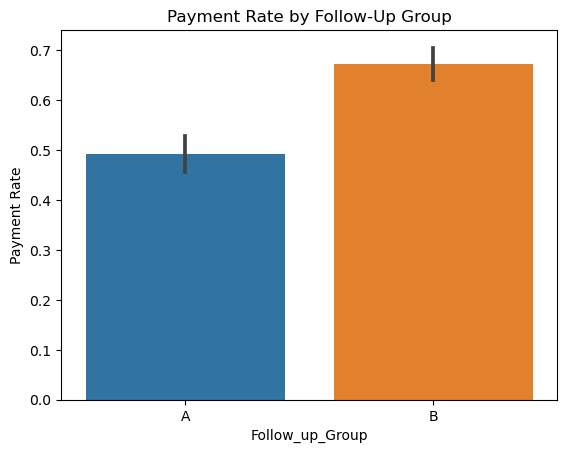

In [77]:
# Payment rate by follow-up group
sns.barplot(x='Follow_up_Group', y='is_paid', data=data, estimator=lambda x: sum(x)/len(x))
plt.title('Payment Rate by Follow-Up Group')
plt.ylabel('Payment Rate')
plt.show()

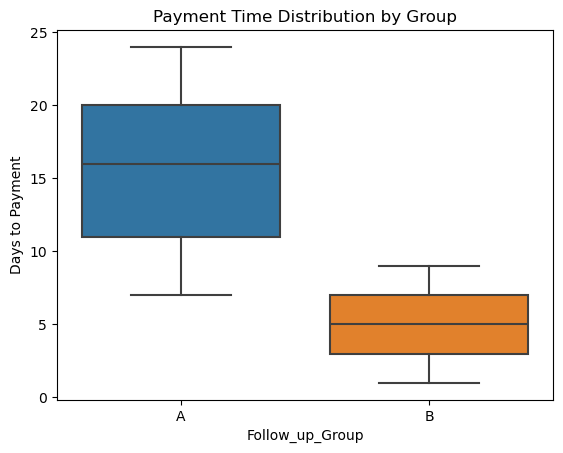

In [78]:
# Payment time distribution
sns.boxplot(x='Follow_up_Group', y='Payment_time_days', data=data[data['Payment_time_days'] > 0])
plt.title('Payment Time Distribution by Group')
plt.ylabel('Days to Payment')
plt.show()